<a href="https://colab.research.google.com/github/EmperorNao/MLHub/blob/main/examples/MultinomialLogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from sklearn import linear_model

In [2]:
def train_test_split(x: np.ndarray,
                     y: np.ndarray,
                     ratio: float = 0) -> ((np.ndarray, np.ndarray), (np.ndarray, np.ndarray)):

    if x.shape[0] != y.shape[0]:
        raise DimensionsException("X and y has different number of objects")

    if 1 < ratio < 0:
        raise ValueError(f"Ratio need to be in [0, 1], provided {ratio}")

    idx_full = range(0, x.shape[0])
    size = ceil(x.shape[0] * ratio)
    idx_train = list(np.random.choice(idx_full, size))
    idx_test = list(set(idx_full).difference(idx_train))

    return (x[idx_train, :], x[idx_test, :]), (y[idx_train], y[idx_test])


class DimensionsException(Exception):

    def __init__(self, s):
        self.msg = s
        super().__init__()

    def __str__(self):
        return self.msg

def accuracy(y_real: np.ndarray, y_pred: np.ndarray) -> float:

    return np.mean(y_real == y_pred)

In [3]:
import numpy as np


def sgd(x: np.ndarray,
        y: np.ndarray,
        loss_fn, grad_loss_fn,
        lr = 1e-4,
        smart_init=False,
        w: np.ndarray = None,
        lam: float = 0.9,
        eps=1e-6,
        batch_size=1, # менять bs нельзя, данный метод не работает для нескольких элементов в батче
        max_iter=10000,
        logging=False) -> (np.ndarray, float):

    n_features = x.shape[1]
    n_objects = x.shape[0]

    if w is None:
        if not smart_init:
            w = np.zeros(n_features)
            for i in range(n_features):
                w[i] = np.random.normal(0, 1 / (2 * x.shape[0]))

        w = np.expand_dims(w, -1)

    grad_coef = np.asarray([grad_loss_fn(w, np.expand_dims(x[i], 0), y[i]) for i in range(n_objects)])
    grad_sum = np.sum(grad_coef, axis=0)


    delta_q = float("inf")
    delta_w = np.array([float("inf")] * n_features)
    loss = loss_fn(w, x, y)
    q = np.sum(loss) / x.shape[0]

    history = []
    iter = 0

    if logging:
        print(f"Iter = {iter}, Loss = {q}")

    while iter < max_iter and abs(delta_q) > eps:# or abs(np.sum(delta_w)) > (eps * n_features)):

        idx_obj = np.random.choice(range(n_objects), size=batch_size)
        x_obj = x[idx_obj,:]
        y_obj = y[idx_obj]

        loss = np.sum(loss_fn(w, x_obj, y_obj)) / x_obj.shape[0]

        grad = grad_loss_fn(w, x_obj, y_obj)
        grad_sum -= grad_coef[idx_obj[0]]
        grad_coef[idx_obj[0]] = grad
        grad_sum += grad_coef[idx_obj[0]]

        delta_w = lr * grad_sum / n_objects
        w = w - delta_w

        new_q = lam * loss + (1 - lam) * q
        delta_q = new_q - q
        q = new_q

        #print(f"iter {iter}\ngrad = {grad}\ndelta w = {delta_w}\ndelta q = {delta_q}\n\n")
        iter += 1
        history.append(q)

        if logging:
            print(f"Iter = {iter}, Loss = {q}, delta_w = {delta_w}")

    return w, q, history


class SGDOptimizer:

    def __init__(self,
                 lr: float =1e-4,
                 smart_init=False,
                 lam: float = 0.9,
                 eps = 1e-6,
                 max_iter = 10000,
                 logging=False):

        self.lr = lr
        self.smart_init = smart_init
        self.lam = lam
        self.eps = eps
        self.max_iter = max_iter
        self.logging = logging

    def fit(self,
            x: np.ndarray,
            y: np.ndarray,
            loss_fn,
            grad_loss_fn,
            w: np.ndarray = None,
            get_hist=False) -> (np.ndarray, float):
        # weight and quality

        res = sgd(x, y, loss_fn, grad_loss_fn,
                   self.lr, self.smart_init, w, self.lam, self.eps, 1, self.max_iter, self.logging)

        if get_hist:
            return res

        else:
            return res[0], res[1]


In [4]:
class LogisticRegression:

    def __init__(self, weights: np.ndarray = None, L2_coefficient: float = 0, logging=False):

        self.weights = weights
        self.L2_coefficient = L2_coefficient if L2_coefficient != 0 else 0.05
        self.logging=logging

    def fit(self, x: np.ndarray, y: np.ndarray, optimizer):

        if x.shape[0] != y.shape[0]:
            raise DimensionsException("X and y has different number of objects")

        n_objects = x.shape[0]
        n_features = x.shape[1] + 1
        self.classes = np.unique(y)

        n_classes = self.classes.shape[0]

        ones = 1 * np.ones((n_objects, 1))

        self.weights = np.random.normal(scale=1/(2 * np.pi * x.shape[0]), size=(n_features, n_classes))

        x_padded = np.hstack([x, ones])

        y_transformed = []
        for el_y in y:
            z = np.zeros(n_classes)
            z[np.where(self.classes == el_y)] = 1
            y_transformed.append(z)

        w, q, history = optimizer.fit(x_padded, np.array(y_transformed), self.loss, self.grad_loss, w=self.weights, get_hist=True)

        self.weights = w
        return history

    def softmax(self, v):
        # v = m * k
        # outp = m * k

        exp = np.exp(v)
        denom = np.expand_dims(np.sum(exp, axis=1), -1)
        ret = exp / denom
        return ret

    def softmax_grad(self, v):
        # v = m x k
        # outp = m x k x k

        sm = self.softmax(v)
        m = v.shape[0]
        c = v.shape[1]
        return np.array(np.array([np.array([sm[k][i] * (1 - sm[i]) if i == j else -1 * sm[k][i] * sm[k][j] for i in range(c)]) for j in range(c)]) for k in range(m))

    def loss(self, w: np.ndarray, x: np.ndarray, y: np.ndarray):
        # x.shape = m x n
        # y.shape = m x k
        # w.shape = n x k
        # outp = 1 x 1

        sm = self.softmax(np.dot(x, w))
        return -1 * np.mean(np.sum(y * np.log(sm), axis=1), axis=0)

    def grad_loss(self, w: np.ndarray, x: np.ndarray, y: np.ndarray):
        # x.shape = m x n
        # y.shape = m x k
        # w.shape = n x k
        # outp = n x k
        
        sm = self.softmax(np.dot(x, w))
        prod = sm * y
        diff = prod - y
        return np.dot(x.T, diff)

    def predict(self, x: np.ndarray) -> np.ndarray:

        n_objects = x.shape[0]
        n_features = x.shape[1] + 1
        ones = 1 * np.ones((n_objects, 1))

        x_padded = np.hstack([x, ones])

        prob = self.softmax(self.softmax(np.dot(x_padded, self.weights)))
        pred = np.argmax(prob, axis=1)
        if self.logging:
            print(prob)
            print(pred)

        return pred

In [5]:
def log_test():

    for scale in [1, 2, 3, 4, 5]:

        optim = SGDOptimizer(lr=1e-2, max_iter=10000, lam=0.95)
        simple = LogisticRegression()
        sklearn = linear_model.LogisticRegression()

        N = 200
        N2 = 25

        n_1 = int(N // 2 + np.random.randint(-N2, N2))
        n_2 = int(N // 2 + np.random.randint(-N2, N2))
        n_3 = int(N // 2 + np.random.randint(-N2, N2))

        x_1 = 10
        y_1 = 10

        x_2 = 0
        y_2 = -10

        x_3 = -10
        y_3 = 10

        pairs_1 = np.array([np.array(
            [x_1 + np.random.normal(scale=scale), y_1 + np.random.normal(scale=scale)])
            for i in range(0, n_1)])

        answers_1 = np.array([0] * n_1)

        pairs_2 = np.array([np.asarray(
            [x_2 + np.random.normal(scale=scale), y_2 + np.random.normal(scale=scale)])
            for i in range(0, n_2)])
        answers_2 = np.array([1] * n_2)

        pairs_3 = np.array([np.asarray(
            [x_3 + np.random.normal(scale=scale), y_3 + np.random.normal(scale=scale)])
            for i in range(0, n_3)])
        answers_3 = np.array([2] * n_3)

        x = np.vstack([pairs_1, pairs_2, pairs_3])
        y = np.hstack([answers_1, answers_2, answers_3])

        idx = np.random.permutation([i for i in range(x.shape[0])])

        x = x[idx]
        y = y[idx]

        x_pair, y_pair = train_test_split(x, y, ratio=0.75)

        x_train, x_test = x_pair
        y_train, y_test = y_pair

        simple.fit(x_train, y_train, optim)
        sklearn.fit(x_train, y_train)

        y_pred_simple = simple.predict(x_test)
        y_pred_sklearn = sklearn.predict(x_test)

        print(f"Scale = {scale}")
        print(f"ACC on SLKEARN = {accuracy(y_test, y_pred_sklearn)}")
        print(f"ACC on our LR = {accuracy(y_test, y_pred_simple)}")

        fig = plt.figure(figsize = (15, 10))

        idx_zero = y_test == 0
        idx_one = y_test == 1
        idx_two = y_test == 2

        plt.title("Three classes")

        plt.scatter(x_test[idx_zero, 0], x_test[idx_zero, 1], color="blue", s=50)

        plt.scatter(x_test[idx_one, 0], x_test[idx_one, 1], color="red", s=50)

        plt.scatter(x_test[idx_two, 0], x_test[idx_two, 1], color="yellow", s=50)

        b = simple.weights[2][0]
        w1 = simple.weights[0][0]
        w2 = simple.weights[1][0]
        x = [i for i in range(-15, 15)]
        y = [-i * w1 / w2 - b / w2 for i in x]
        plt.plot(x, y, color="blue")

        b = simple.weights[2][1]
        w1 = simple.weights[0][1]
        w2 = simple.weights[1][1]
        x = [i for i in range(-15, 15)]
        y = [-i * w1 / w2 - b / w2 for i in x]
        plt.plot(x, y, color="red")

        b = simple.weights[2][2]
        w1 = simple.weights[0][2]
        w2 = simple.weights[1][2]
        x = [i for i in range(-15, 15)]
        y = [-i * w1 / w2 - b / w2 for i in x]
        plt.plot(x, y, color="yellow")


        plt.ylim([-25, 25])

        plt.show()


Scale = 1
ACC on SLKEARN = 1.0
ACC on our LR = 1.0


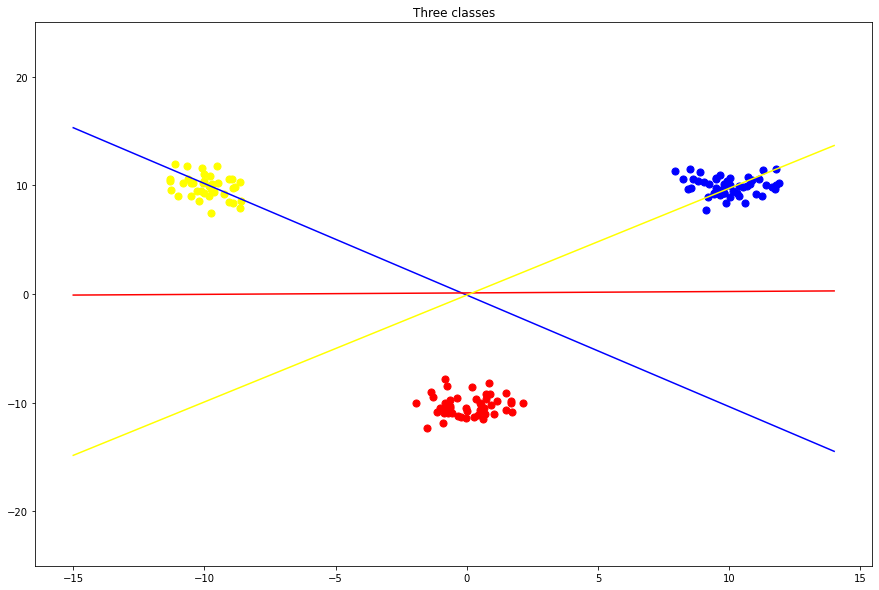

Scale = 2
ACC on SLKEARN = 1.0
ACC on our LR = 1.0


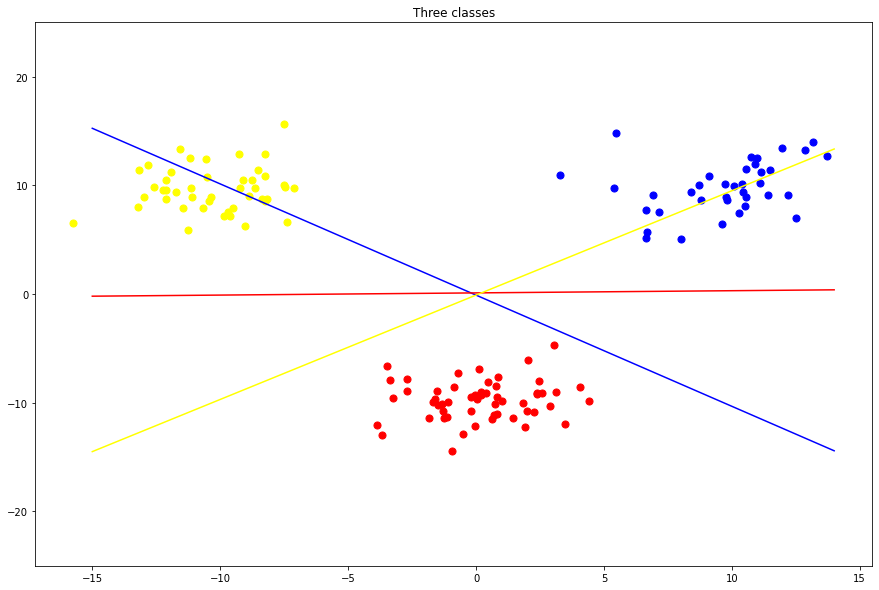

Scale = 3
ACC on SLKEARN = 1.0
ACC on our LR = 0.9927007299270073


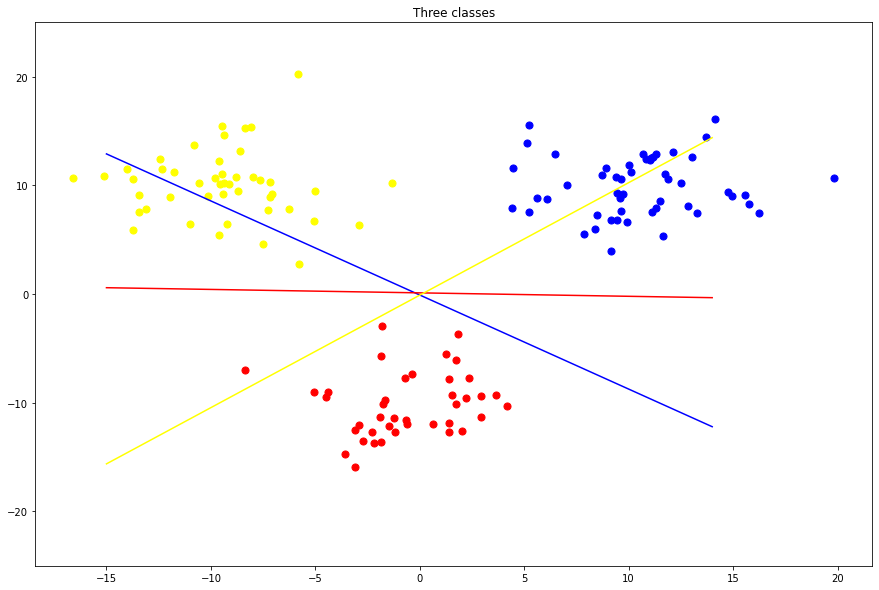

Scale = 4
ACC on SLKEARN = 0.9927536231884058
ACC on our LR = 0.9637681159420289


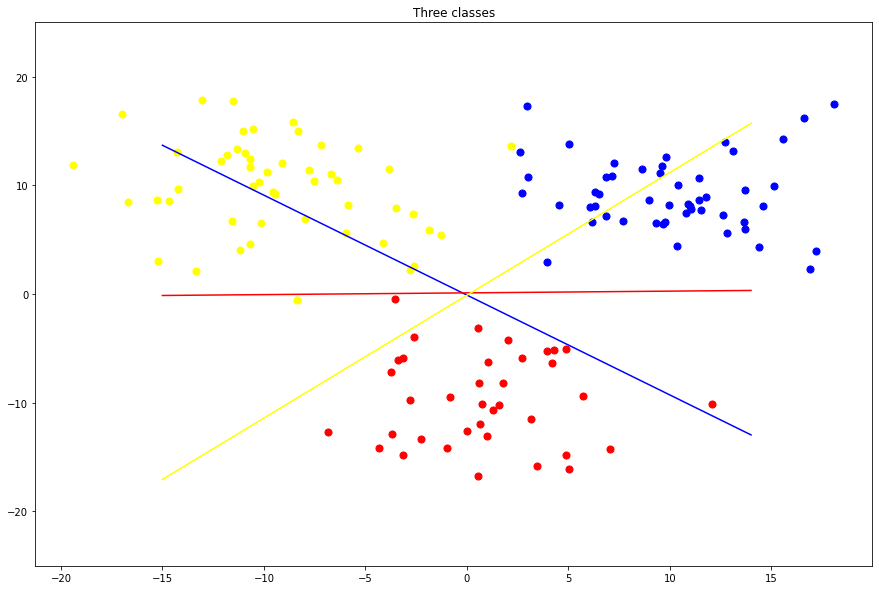

Scale = 5
ACC on SLKEARN = 0.9794520547945206
ACC on our LR = 0.9726027397260274


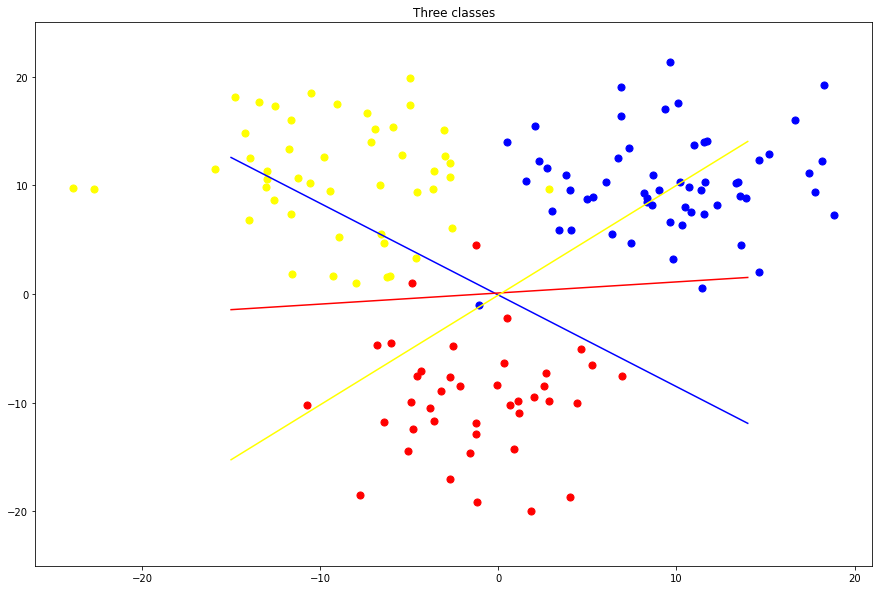

In [6]:
log_test()